In [1]:
#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [2]:
#데이터 불러오기
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
building_info =  pd.read_csv('./data/building_info.csv')

train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)


train_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [3]:
test_df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [4]:
building_info.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,Other Buildings,110634.00,39570.00,-,-,-
1,2,Other Buildings,122233.47,99000.00,-,-,-
2,3,Other Buildings,171243.00,113950.00,40,-,-
3,4,Other Buildings,74312.98,34419.62,60,-,-
4,5,Other Buildings,205884.00,150000.00,-,2557,1000


Train 과 Test의 차이: columns에 일조, 일사, 전력 소비량이 없다.

## 전처리 (병합, 빈칸 채우기, 형 변환, num_date_time 삭제)

In [5]:

pd.set_option('display.max_columns', 30)

def merge(df):
    df = df.fillna(0)
    date = pd.to_datetime(df.date_time)
    df['hour'] = date.dt.hour
    df['day'] = date.dt.weekday
    df['month'] = date.dt.month
    df['week'] = date.dt.weekofyear
    
    # 'building_number'를 기준으로 두 데이터프레임 병합 및 전처리
    merged_df = pd.merge(df, building_info, on='building_number',how='right')
    #merge후 전처리
    merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].replace('-', 0)
    merged_df['ess_capacity'] = merged_df['ess_capacity'].replace('-', 0)
    merged_df['pcs_capacity'] = merged_df['pcs_capacity'].replace('-', 0)

    merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].astype('float64')
    merged_df['ess_capacity'] = merged_df['ess_capacity'].astype('float64')
    merged_df['pcs_capacity'] = merged_df['pcs_capacity'].astype('float64')
    return merged_df.drop(columns =['num_date_time','building_type'])


merged_train_df = merge(train_df)
merged_test_df = merge(test_df)

#######################################
## 건물별, 요일별, 시간별 발전량 평균 넣어주기
#######################################
power_mean = pd.pivot_table(merged_train_df, values = 'power_consumption', index = ['building_number', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
#######################################
## 건물별 시간별 발전량 평균 넣어주기
#######################################
power_hour_mean = pd.pivot_table(merged_train_df, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
    #######################################
## 건물별 시간별 발전량 표준편차 넣어주기
#######################################
power_hour_std = pd.pivot_table(merged_train_df, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()

In [6]:
def preprocessing(df):
    df['day_hour_mean'] = df.progress_apply(lambda x : power_mean.loc[(power_mean.building_number == x['building_number']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'power_consumption'].values[0], axis = 1)
    df['hour_mean'] = df.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.building_number == x['building_number']) & (power_hour_mean.hour == x['hour']) ,'power_consumption'].values[0], axis = 1)   
    df['hour_std'] = df.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.building_number == x['building_number']) & (power_hour_std.hour == x['hour']) ,'power_consumption'].values[0], axis = 1)
    
    def CDH(xs):
        ys = []
        for i in range(len(xs)):
            if i < 11:
                ys.append(np.sum(xs[:(i+1)]-26))
            else:
                ys.append(np.sum(xs[(i-11):(i+1)]-26))
        return np.array(ys)

    cdhs = np.array([])
    for num in range(1,101,1):
        temp = df[df['building_number'] == num]
        cdh = CDH(temp['temperature'].values)
        cdhs = np.concatenate([cdhs, cdh])
    df['CDH'] = cdhs
    
    ### 공휴일 변수 추가
    df['holiday'] = df.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
    df.loc[('2022-08-15'<=df.date_time)&(df.date_time<'2022-06-01')&(df.date_time<'2022-06-06'), 'holiday'] = 1

    ## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
    df['sin_time'] = np.sin(2*np.pi*df.hour/24)
    df['cos_time'] = np.cos(2*np.pi*df.hour/24)
    
    ## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
    df['THI'] = 9/5*df['temperature'] - 0.55*(1-df['humidity']/100)*(9/5*df['humidity']-26)+32
    
    
    return df

merged_train_df =preprocessing(merged_train_df)
merged_test_df =preprocessing(merged_test_df)


100%|██████████| 16800/16800 [00:05<00:00, 2850.37it/s]


In [7]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   building_number       204000 non-null  int64  
 1   date_time             204000 non-null  object 
 2   temperature           204000 non-null  float64
 3   rainfall              204000 non-null  float64
 4   windspeed             204000 non-null  float64
 5   humidity              204000 non-null  float64
 6   sunshine              204000 non-null  float64
 7   solar_radiation       204000 non-null  float64
 8   power_consumption     204000 non-null  float64
 9   hour                  204000 non-null  int64  
 10  day                   204000 non-null  int64  
 11  month                 204000 non-null  int64  
 12  week                  204000 non-null  int64  
 13  total_area            204000 non-null  float64
 14  cooling_area          204000 non-null  float64
 15  

In [8]:
## save the preprocessed data
merged_train_df.drop(columns=['date_time']).to_csv('./data/train_preprocessed_lbw.csv')
merged_test_df.drop(columns=['date_time']).to_csv('./data/test_preprocessed_lbw.csv')

## 추가 전처리

In [9]:
## save the preprocessed data
merged_train_df = pd.read_csv('./data/train_preprocessed_lbw.csv')
merged_test_df = pd.read_csv('./data/test_preprocessed_lbw.csv')



## 원핫 인코딩(안해도 됨)

In [10]:
# merged_train_df = pd.get_dummies(merged_train_df, prefix=["bt:"], columns=["building_type"])
# merged_train_df.head()
# merged_test_df = pd.get_dummies(merged_test_df, prefix=["bt:"], columns=["building_type"])
# merged_test_df.head()

## 성능 평가지표 정의 및 SMAPE 정의

In [11]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

## 최적의 파라미터 탐색

In [12]:

df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1),
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1),
        'subsample' :np.arange(0.8, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)

#tscv = TimeSeriesSplit(n_splits=3)
smape_score = make_scorer(SMAPE, greater_is_better=False)

for i in tqdm(np.arange(1, 101, 1)):
    y = merged_train_df.loc[merged_train_df.building_number == i, 'power_consumption']
    x = merged_train_df.loc[merged_train_df.building_number == i].drop(['power_consumption'], axis=1)
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)

    pds = PredefinedSplit(np.append(-np.ones(len(x_train)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed=0),
                       param_grid=grid, scoring=smape_score, cv=pds, refit=True, verbose=True)
    
    # gcv = GridSearchCV(estimator = XGBRegressor(seed = 0, gpu_id = 1, tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
    #                     param_grid = grid, scoring = smape_score, cv = pds, refit = True, verbose = True)

    gcv.fit(x_train, y_train)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index=[0])], axis=0)
    df.to_csv('./parameters/hyperparameter_xgb2.csv', index=False) # save the tuned parameters


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 1 folds for each of 168 candidates, totalling 168 fits


  1%|          | 1/100 [00:17<28:45, 17.43s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building1|| SMAPE : 44.05011050030062
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  2%|▏         | 2/100 [00:33<27:37, 16.91s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building2|| SMAPE : 40.93299033652273
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  3%|▎         | 3/100 [00:51<27:29, 17.00s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building3|| SMAPE : 35.567815896673636
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  4%|▍         | 4/100 [01:04<25:13, 15.77s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building4|| SMAPE : 41.91721212129656
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  5%|▌         | 5/100 [01:22<25:43, 16.24s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building5|| SMAPE : 48.14368084261817
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  6%|▌         | 6/100 [01:37<24:49, 15.85s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building6|| SMAPE : 46.68862233024547
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  7%|▋         | 7/100 [01:54<25:32, 16.47s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building7|| SMAPE : 42.04868074194748
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  8%|▊         | 8/100 [02:10<24:47, 16.17s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building8|| SMAPE : 44.80893851382318
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  9%|▉         | 9/100 [02:27<24:45, 16.33s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building9|| SMAPE : 44.75269618450878
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 10%|█         | 10/100 [02:42<24:01, 16.02s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building10|| SMAPE : 37.91040020661293
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 11%|█         | 11/100 [02:56<22:52, 15.42s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building11|| SMAPE : 43.15908079781213
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 12%|█▏        | 12/100 [03:12<22:48, 15.55s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building12|| SMAPE : 45.521840472815185
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 13%|█▎        | 13/100 [03:27<22:13, 15.33s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building13|| SMAPE : 45.82333737514652
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 14%|█▍        | 14/100 [03:44<22:59, 16.04s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building14|| SMAPE : 38.655823238035715
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 15%|█▌        | 15/100 [03:59<22:10, 15.65s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building15|| SMAPE : 41.97214132636009
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 16%|█▌        | 16/100 [04:16<22:20, 15.96s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building16|| SMAPE : 42.002761165630226
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 17%|█▋        | 17/100 [04:33<22:38, 16.36s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building17|| SMAPE : 49.64899476731995
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 18%|█▊        | 18/100 [04:50<22:34, 16.52s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building18|| SMAPE : 49.577686390830195
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 19%|█▉        | 19/100 [05:07<22:34, 16.73s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building19|| SMAPE : 51.595513734319205
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 20%|██        | 20/100 [05:24<22:27, 16.84s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building20|| SMAPE : 49.096918389658136
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 21%|██        | 21/100 [05:41<22:07, 16.80s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building21|| SMAPE : 45.65262547117323
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 22%|██▏       | 22/100 [05:56<21:03, 16.20s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building22|| SMAPE : 45.44369393654534
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 23%|██▎       | 23/100 [06:10<20:03, 15.64s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building23|| SMAPE : 46.50317481613356
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 24%|██▍       | 24/100 [06:27<20:20, 16.06s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building24|| SMAPE : 44.863045960106135
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 25%|██▌       | 25/100 [06:43<19:58, 15.98s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building25|| SMAPE : 46.98896372780894
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 26%|██▌       | 26/100 [06:59<19:47, 16.04s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building26|| SMAPE : 45.56267691167336
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 27%|██▋       | 27/100 [07:15<19:20, 15.90s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building27|| SMAPE : 44.057367365769835
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 28%|██▊       | 28/100 [07:31<19:05, 15.90s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building28|| SMAPE : 40.51755030466037
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 29%|██▉       | 29/100 [07:46<18:44, 15.84s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building29|| SMAPE : 45.1000367972176
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 30%|███       | 30/100 [08:05<19:24, 16.63s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building30|| SMAPE : 47.219779995811216
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 31%|███       | 31/100 [08:21<19:09, 16.67s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building31|| SMAPE : 40.92084185099526
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 32%|███▏      | 32/100 [08:31<16:31, 14.58s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building32|| SMAPE : 44.39789253831639
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 33%|███▎      | 33/100 [08:41<14:38, 13.11s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building33|| SMAPE : 44.977112989289886
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 34%|███▍      | 34/100 [08:51<13:32, 12.32s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building34|| SMAPE : 44.49219541462247
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 35%|███▌      | 35/100 [09:01<12:22, 11.42s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building35|| SMAPE : 44.96127409451128
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 36%|███▌      | 36/100 [09:09<11:16, 10.58s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building36|| SMAPE : 44.97970172763815
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 37%|███▋      | 37/100 [09:27<13:30, 12.87s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building37|| SMAPE : 46.10453110075219
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 38%|███▊      | 38/100 [09:46<15:07, 14.64s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building38|| SMAPE : 44.49063683399312
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 39%|███▉      | 39/100 [10:04<15:51, 15.60s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building39|| SMAPE : 47.447265158329344
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 40%|████      | 40/100 [10:24<16:51, 16.86s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building40|| SMAPE : 46.15111361871219
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 41%|████      | 41/100 [10:43<17:07, 17.42s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building41|| SMAPE : 45.50204313974386
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 42%|████▏     | 42/100 [11:01<17:13, 17.81s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building42|| SMAPE : 47.17493461507984
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 43%|████▎     | 43/100 [11:20<17:04, 17.97s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building43|| SMAPE : 43.74922567495753
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 44%|████▍     | 44/100 [11:37<16:38, 17.83s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building44|| SMAPE : 42.82706140434131
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 45%|████▌     | 45/100 [11:53<15:45, 17.20s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building45|| SMAPE : 46.387883176970355
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 46%|████▌     | 46/100 [12:10<15:23, 17.10s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building46|| SMAPE : 44.5998341610954
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 47%|████▋     | 47/100 [12:26<14:51, 16.83s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building47|| SMAPE : 42.689433524564755
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 48%|████▊     | 48/100 [12:43<14:33, 16.81s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building48|| SMAPE : 45.93646086885981
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 49%|████▉     | 49/100 [12:59<14:03, 16.55s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building49|| SMAPE : 47.59287410084077
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 50%|█████     | 50/100 [13:14<13:31, 16.23s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building50|| SMAPE : 42.670984302686044
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 51%|█████     | 51/100 [13:32<13:35, 16.64s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building51|| SMAPE : 46.3144745201936
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 52%|█████▏    | 52/100 [13:52<14:06, 17.65s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building52|| SMAPE : 47.077263030081646
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 53%|█████▎    | 53/100 [14:15<15:09, 19.34s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building53|| SMAPE : 39.36474661817669
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 54%|█████▍    | 54/100 [14:38<15:44, 20.53s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building54|| SMAPE : 57.16802820900973
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 55%|█████▌    | 55/100 [14:52<13:55, 18.57s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building55|| SMAPE : 45.24897265072587
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 56%|█████▌    | 56/100 [15:05<12:23, 16.89s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building56|| SMAPE : 44.49120502317458
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 57%|█████▋    | 57/100 [15:26<12:49, 17.88s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building57|| SMAPE : 44.99760275555632
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 58%|█████▊    | 58/100 [15:36<11:02, 15.77s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building58|| SMAPE : 45.52063789532586
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 59%|█████▉    | 59/100 [15:58<11:58, 17.54s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building59|| SMAPE : 44.752624135643444
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 60%|██████    | 60/100 [16:18<12:13, 18.34s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building60|| SMAPE : 45.63014605138102
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 61%|██████    | 61/100 [16:42<12:53, 19.84s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building61|| SMAPE : 43.08987031070058
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 62%|██████▏   | 62/100 [17:03<12:55, 20.41s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building62|| SMAPE : 41.90547391909941
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 63%|██████▎   | 63/100 [17:26<12:59, 21.08s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building63|| SMAPE : 41.954831190600125
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 64%|██████▍   | 64/100 [17:47<12:38, 21.06s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building64|| SMAPE : 42.52205072770661
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 65%|██████▌   | 65/100 [18:10<12:41, 21.75s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building65|| SMAPE : 37.5766012979054
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 66%|██████▌   | 66/100 [18:32<12:14, 21.61s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building66|| SMAPE : 46.37622992932393
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 67%|██████▋   | 67/100 [18:53<11:46, 21.42s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building67|| SMAPE : 35.456335865584364
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 68%|██████▊   | 68/100 [19:15<11:32, 21.63s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building68|| SMAPE : 41.619407002023856
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 69%|██████▉   | 69/100 [19:35<10:56, 21.19s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building69|| SMAPE : 43.94266578761779
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 70%|███████   | 70/100 [19:56<10:39, 21.31s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building70|| SMAPE : 47.84983949077842
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 71%|███████   | 71/100 [20:17<10:09, 21.03s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building71|| SMAPE : 46.62355152510072
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 72%|███████▏  | 72/100 [20:35<09:26, 20.24s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building72|| SMAPE : 48.82518835631429
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 73%|███████▎  | 73/100 [20:55<08:59, 19.98s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building73|| SMAPE : 43.97045682638319
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 74%|███████▍  | 74/100 [21:17<08:59, 20.74s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building74|| SMAPE : 48.23151825702672
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 75%|███████▌  | 75/100 [21:43<09:16, 22.26s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building75|| SMAPE : 44.331567914628344
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 76%|███████▌  | 76/100 [22:03<08:36, 21.53s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building76|| SMAPE : 45.87050342651003
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 77%|███████▋  | 77/100 [22:22<08:02, 20.97s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building77|| SMAPE : 46.6167109980073
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 78%|███████▊  | 78/100 [22:43<07:41, 20.98s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building78|| SMAPE : 48.782890765422515
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 79%|███████▉  | 79/100 [23:04<07:17, 20.82s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building79|| SMAPE : 46.95904430499853
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 80%|████████  | 80/100 [23:26<07:01, 21.08s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building80|| SMAPE : 47.54942964616381
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 81%|████████  | 81/100 [23:46<06:37, 20.91s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building81|| SMAPE : 44.16096033203302
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 82%|████████▏ | 82/100 [24:07<06:18, 21.04s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building82|| SMAPE : 45.394589436981306
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 83%|████████▎ | 83/100 [24:30<06:05, 21.48s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building83|| SMAPE : 46.32775909630353
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 84%|████████▍ | 84/100 [24:53<05:50, 21.90s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building84|| SMAPE : 45.875245768576185
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 85%|████████▌ | 85/100 [25:15<05:29, 21.93s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building85|| SMAPE : 46.55780678569076
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 86%|████████▌ | 86/100 [25:42<05:29, 23.50s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building86|| SMAPE : 46.95403438057308
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 87%|████████▋ | 87/100 [26:05<05:02, 23.30s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building87|| SMAPE : 46.230886245458215
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 88%|████████▊ | 88/100 [26:27<04:36, 23.07s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building88|| SMAPE : 49.980167832502964
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 89%|████████▉ | 89/100 [26:50<04:12, 22.99s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building89|| SMAPE : 49.57500678310915
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 90%|█████████ | 90/100 [27:14<03:51, 23.16s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building90|| SMAPE : 51.20726632322171
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 91%|█████████ | 91/100 [27:36<03:26, 23.00s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building91|| SMAPE : 48.02833323990613
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 92%|█████████▏| 92/100 [27:58<03:00, 22.51s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building92|| SMAPE : 46.444641705128085
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 93%|█████████▎| 93/100 [28:18<02:32, 21.81s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building93|| SMAPE : 42.6398268380545
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 94%|█████████▍| 94/100 [28:39<02:08, 21.49s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building94|| SMAPE : 44.9511403645468
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 95%|█████████▌| 95/100 [29:01<01:48, 21.76s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building95|| SMAPE : 30.18566018133476
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 96%|█████████▌| 96/100 [29:20<01:24, 21.03s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building96|| SMAPE : 40.96398353867539
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 97%|█████████▋| 97/100 [29:44<01:05, 21.80s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building97|| SMAPE : 47.153015261591186
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 98%|█████████▊| 98/100 [30:07<00:44, 22.20s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building98|| SMAPE : 34.89469869273272
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 99%|█████████▉| 99/100 [30:28<00:21, 21.86s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building99|| SMAPE : 42.19013551936372
Fitting 1 folds for each of 168 candidates, totalling 168 fits


100%|██████████| 100/100 [30:51<00:00, 18.51s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building100|| SMAPE : 46.51010254135487


In [14]:
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb2_lbw.csv')

In [15]:
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list

for i in tqdm(np.arange(1,101,1)):
    y = merged_train_df.loc[merged_train_df.building_number == i, 'power_consumption']
    x = merged_train_df.loc[merged_train_df.building_number == i].drop(['power_consumption'], axis=1)
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)

    xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = xgb_params.iloc[i-1, 2],
                           max_depth = xgb_params.iloc[i-1, 3], colsample_bytree = xgb_params.iloc[i-1, 4],
                           subsample = xgb_params.iloc[i-1, 5], seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),
                                            (x_test, y_test)], early_stopping_rounds=300, verbose=False)
    y_pred = xgb_reg.predict(x_test)
    pred = pd.Series(y_pred)

    sm = SMAPE(y_test, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration+1) ## 실제 best iteration은 이 값에 +1 해주어야 함.


100%|██████████| 100/100 [03:46<00:00,  2.27s/it]


In [ ]:
alpha_list = []
smape_list = []
for i in tqdm(np.arange(1,101,1)):
    y = merged_train_df.loc[merged_train_df.building_number == i, 'power_consumption']
    x = merged_train_df.loc[merged_train_df.building_number == i].drop(['power_consumption'], axis=1)
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i-1], eta = 0.01, min_child_weight = xgb_params.iloc[i-1, 2],
                      max_depth = xgb_params.iloc[i-1, 3], colsample_bytree = xgb_params.iloc[i-1, 4], subsample = xgb_params.iloc[i-1, 5])

    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_test)
    best_alpha = 0
    score0 = SMAPE(y_test,pred0)

    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i-1], eta = 0.01, min_child_weight = xgb_params.iloc[i-1, 2],
                      max_depth = xgb_params.iloc[i-1, 3], colsample_bytree = xgb_params.iloc[i-1, 4], subsample = xgb_params.iloc[i-1, 5])
        xgb.set_params(**{'objective' : weighted_mse(j)})

        xgb.fit(x_train, y_train)
        pred1 = xgb.predict(x_test)
        score1 = SMAPE(y_test, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1

    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print("building {} || best score : {} || alpha : {}".format(i, score0, best_alpha))
    

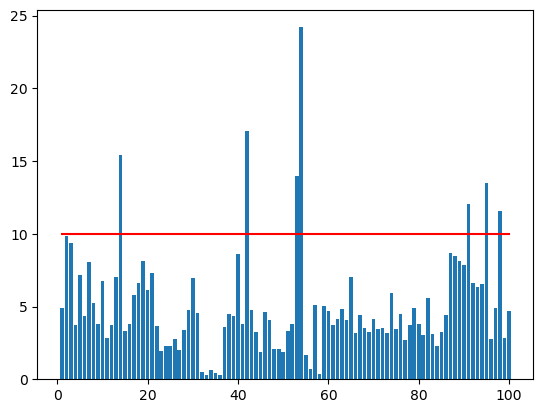

In [17]:
no_df = pd.DataFrame({'score':smape_list})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
plt.plot([1,100], [10, 10], color = 'red')

In [18]:
xgb_params['alpha'] = alpha_list
xgb_params['best_it'] = best_it
xgb_params.head()

,n_estimators,eta,min_child_weight,max_depth,colsample_bytree,subsample,alpha,best_it
0,100,0.01,6,8,0.9,0.9,10,491
1,100,0.01,7,8,0.9,0.9,0,627
2,100,0.01,5,3,0.9,0.9,1,204
3,100,0.01,1,4,0.9,0.9,75,304
4,100,0.01,7,8,0.8,0.9,100,657


In [19]:
merged_test_df.head()


,Unnamed: 0,building_number,temperature,rainfall,windspeed,humidity,hour,day,month,week,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,day_hour_mean,hour_mean,hour_std,CDH,holiday,sin_time,cos_time,THI
0,0,1,23.5,0.0,2.2,72,0,3,8,34,110634.0,39570.0,0.0,0.0,0.0,1627.80,1706.318118,446.882767,-2.5,0,0.000000,1.000000,58.3456
1,1,1,23.0,0.0,0.9,72,1,3,8,34,110634.0,39570.0,0.0,0.0,0.0,1550.08,1622.620235,439.662704,-5.5,0,0.258819,0.965926,57.4456
2,2,1,22.7,0.0,1.5,75,2,3,8,34,110634.0,39570.0,0.0,0.0,0.0,1431.12,1506.971294,412.071906,-8.8,0,0.500000,0.866025,57.8725
3,3,1,22.1,0.0,1.3,78,3,3,8,34,110634.0,39570.0,0.0,0.0,0.0,1372.20,1437.365647,391.205981,-12.7,0,0.707107,0.707107,57.9376
4,4,1,21.8,0.0,1.0,77,4,3,8,34,110634.0,39570.0,0.0,0.0,0.0,1381.72,1447.321412,381.099697,-16.9,0,0.866025,0.500000,56.9961


In [20]:
merged_train_df.head()

,Unnamed: 0,building_number,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,hour,day,month,week,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,day_hour_mean,hour_mean,hour_std,CDH,holiday,sin_time,cos_time,THI
0,0,1,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,0,2,6,22,110634.0,39570.0,0.0,0.0,0.0,1774.744615,1706.318118,446.882767,-7.4,0,0.000000,1.000000,49.6576
1,1,1,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,1,2,6,22,110634.0,39570.0,0.0,0.0,0.0,1687.347692,1622.620235,439.662704,-15.4,0,0.258819,0.965926,47.7625
2,2,1,17.7,0.0,1.5,45.0,0.0,0.0,974.88,2,2,6,22,110634.0,39570.0,0.0,0.0,0.0,1571.483077,1506.971294,412.071906,-23.7,0,0.500000,0.866025,47.2225
3,3,1,16.7,0.0,1.4,48.0,0.0,0.0,953.76,3,2,6,22,110634.0,39570.0,0.0,0.0,0.0,1522.153846,1437.365647,391.205981,-33.0,0,0.707107,0.707107,44.7856
4,4,1,18.4,0.0,2.8,43.0,0.0,0.0,986.40,4,2,6,22,110634.0,39570.0,0.0,0.0,0.0,1506.793846,1447.321412,381.099697,-40.6,0,0.866025,0.500000,49.0061


In [21]:
xgb_params.to_csv('./parameters/hyperparameter_xgb_final2_lbw.csv', index=False)

In [26]:
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb_final2_lbw.csv')
best_it = xgb_params['best_it'].to_list()
#best_it[0]        # 1051
xgb_params.head()

,n_estimators,eta,min_child_weight,max_depth,colsample_bytree,subsample,alpha,best_it
0,100,0.01,6,8,0.9,0.9,10,491
1,100,0.01,7,8,0.9,0.9,0,627
2,100,0.01,5,3,0.9,0.9,1,204
3,100,0.01,1,4,0.9,0.9,75,304
4,100,0.01,7,8,0.8,0.9,100,657


## 학습

In [27]:
preds = np.array([])
for i in tqdm(np.arange(1,101,1)):

    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame

    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = merged_train_df.loc[merged_train_df.building_number == i, 'power_consumption']
        x_train = merged_train_df.loc[merged_train_df.building_number == i].drop(['power_consumption','sunshine','solar_radiation'], axis=1)
        x_test = merged_test_df.loc[merged_test_df.building_number == i]
        
        x_test = x_test[x_train.columns]

        xgb = XGBRegressor(seed = seed, n_estimators = best_it[i-1], eta = 0.01,
                           min_child_weight = xgb_params.iloc[i-1, 2], max_depth = xgb_params.iloc[i-1, 3],
                           colsample_bytree=xgb_params.iloc[i-1, 4], subsample=xgb_params.iloc[i-1, 5])

        if xgb_params.iloc[i-1,6] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb.set_params(**{'objective':weighted_mse(xgb_params.iloc[i-1,6])})

        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기

    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)
    

100%|██████████| 100/100 [11:26<00:00,  6.86s/it]


## 테스트

In [ ]:
preds = pd.Series(preds)

fig, ax = plt.subplots(100, 1, figsize=(100,200), sharex = True)
ax = ax.flatten()
for i in range(100):
    train_y = merged_train_df.loc[merged_train_df.building_number == i+1, 'power_consumption'].reset_index(drop = True)
    test_y = preds[i*168:(i+1)*168]
    ax[i].scatter(np.arange(2040), train_y)
    ax[i].scatter(np.arange(2040, 2040+168) , test_y)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='minor', labelsize=4)
plt.savefig('./predict_xgb2_lbw.png')


## 제출

In [29]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['answer'] = preds
submission.to_csv('./data/submission_xgb_noclip2.csv', index = False)

## 1등코드 원본


In [ ]:
# from sklearn.model_selection import PredefinedSplit, GridSearchCV
# from sklearn.metrics import make_scorer
# df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
# preds = np.array([])

# grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1),
#         'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1),
#         'subsample' :np.arange(0.8, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)

# for i in tqdm(np.arange(1, 101, 1)):
#     y = merged_train_df.loc[merged_train_df.building_number == i, 'power_consumption']
#     x = merged_train_df.loc[merged_train_df.building_number == i, ].drop('power_consumption', axis=1)
#     y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)

#     smape_score = make_scorer(SMAPE, graeter_is_better=False)
#     pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
#     gcv = GridSearchCV(estimator = XGBRegressor(seed = 0, gpu_id = 1,
#                                                  tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
#                          param_grid = grid, scoring = smape_score, cv = pds, refit = True, verbose = True)
#     # gcv = GridSearchCV(estimator = XGBRegressor(seed = 0, gpu_id = 1,
#     #                                             tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
#     #                    param_grid = grid, scoring = smape_score, cv = pds, refit = True, verbose = True)


#     gcv.fit(x_train, y_train)
#     best = gcv.best_estimator_
#     params = gcv.best_params_
#     print(params)
#     pred = best.predict(x_test)
#     building = 'building'+str(i)
#     print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
#     preds = np.append(preds, pred)
#     df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
#     df.to_csv('./hyperparameter_xgb.csv', index = False) # save the tuned parameters

## 